In [1]:
import pypsa
import cartopy.crs as ccrs
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# customize your plot
resolutions = [4, 14, 54]  # must be 3 numbers
plot_capfacs = (
    "solar"  # colors in the back represent capacity factors for this technology
)
cmap = "Greys"  # colormap for upper technology
red_linewidth = 3
red_bussizes = 5e-2

INFO:pypsa.io:Imported network elec_s_4.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s_14.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s_54.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s_4.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s_4.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s_14.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s_54.nc has buses, carriers, generators, lines, loads, storage_units


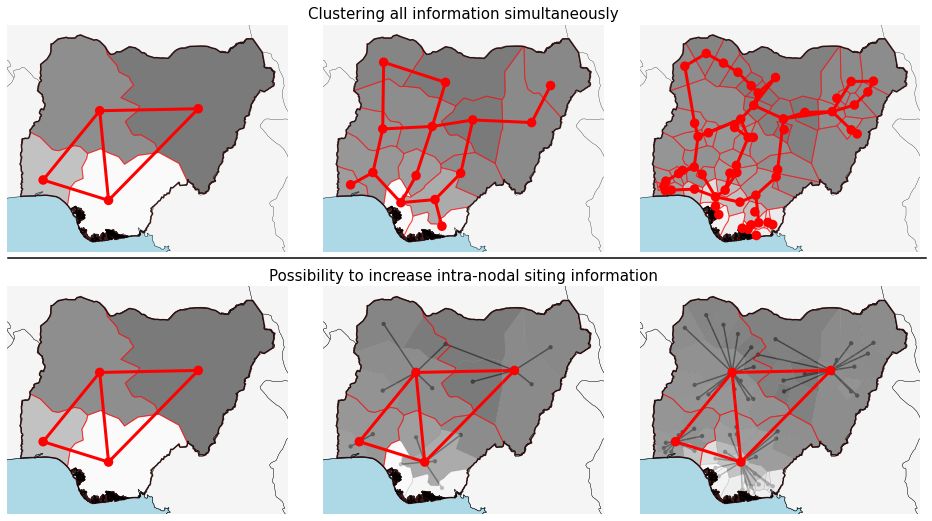

In [3]:
fig, axes = plt.subplots(
    2, 3, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(17, 9)
)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.15)

country = gpd.read_file("../resources/country_shapes.geojson")

c = 0
for ax in axes[0, :]:
    n = pypsa.Network(f"../networks/elec_s_{resolutions[c]}.nc")
    r = gpd.read_file(
        f"../resources/regions_onshore_elec_s_{resolutions[c]}.geojson"
    ).set_index("name")
    factor = n.generators_t.p_max_pu.filter(like=plot_capfacs).mean()
    factor.index = [idx.split(f" {plot_capfacs}")[0] for idx in factor.index]
    r["factor"] = factor

    n.plot(
        color_geomap=True,
        bus_colors="red",
        bus_sizes=red_bussizes,
        line_colors="red",
        line_widths=red_linewidth,
        ax=ax,
    )
    r.boundary.plot(ax=ax, color="red", linewidth=1, alpha=0.5)
    r.plot(ax=ax, column="factor", cmap=cmap, alpha=0.5)
    country.boundary.plot(ax=ax, color="black", alpha=0.75)
    c += 1

c = 0
n = pypsa.Network(f"../networks/elec_s_4.nc")
r = gpd.read_file(f"../resources/regions_onshore_elec_s_4.geojson").set_index("name")
b = pd.read_csv("../resources/busmap_elec_s_4.csv", index_col=0).squeeze("columns")

for ax in axes[1, :]:
    n2 = pypsa.Network(f"../networks/elec_s_{resolutions[c]}.nc")
    r2 = gpd.read_file(
        f"../resources/regions_onshore_elec_s_{resolutions[c]}.geojson"
    ).set_index("name")
    factor = n2.generators_t.p_max_pu.filter(like=plot_capfacs).mean()
    factor.index = [idx.split(f" {plot_capfacs}")[0] for idx in factor.index]
    r2["factor"] = factor

    b2 = pd.read_csv(
        f"../resources/busmap_elec_s_{resolutions[c]}.csv", index_col=0
    ).squeeze("columns")
    n2.mremove("Line", n2.lines.index)

    debug = 0
    for nb in b.unique():
        nl = b2.loc[b[b == nb].index].unique()
        nb = n.buses.loc[nb]
        nb.name = nb.name + " ref"
        n2.madd("Bus", names=[nb.name], x=nb.x, y=nb.y)
        n2.madd(
            "Line", names=nl + f" ref line {debug}", bus0=[nb.name] * len(nl), bus1=nl
        )

        debug += 1

    n.plot(
        color_geomap=True,
        bus_colors="red",
        bus_sizes=red_bussizes,
        line_colors="red",
        line_widths=red_linewidth,
        ax=ax,
    )
    n2.plot(bus_colors="grey", bus_sizes=1e-2, line_colors="grey", zorder=0, ax=ax)
    r2.boundary.plot(ax=ax, color="grey", linewidth=0.25, alpha=0.5)
    r2.plot(ax=ax, column="factor", cmap=cmap, alpha=0.5)
    r.boundary.plot(ax=ax, color="red", linewidth=1, alpha=0.5)
    country.boundary.plot(ax=ax, color="black", alpha=0.75)
    c += 1

axes[0, 1].set_title(
    "Clustering all information simultaneously", fontsize=15
)  # , FontWeight = 'bold')
axes[1, 1].set_title(
    "Possibility to increase intra-nodal siting information", fontsize=15
)  # , FontWeight = 'bold')

# Draw a horizontal line
line = plt.Line2D([0.14, 0.89], [0.52, 0.52], transform=fig.transFigure, color="black")
fig.add_artist(line)

# plt.savefig("visualise_clustering.pdf", bbox_inches="tight")
plt.show()